In [1]:
import tensorflow as tf
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles
from IPython import display
from common import *

np.random.seed(123)
tf.random.set_random_seed(123)

In [2]:
def make_grid(n_samples):
    grid_x, grid_y = np.meshgrid(np.linspace(0.0, 1.0, 5),
                                 np.linspace(0.0, 1.0, 5))
    centers = np.c_[grid_x.ravel(), grid_y.ravel()]
    x, _ = make_blobs(n_samples=n_samples,
                      cluster_std=np.zeros(25)+0.001,
                      centers=centers,
                      random_state=123)
    # Scale to (0, 1)
    x = (x - x.min())/(x - x.min()).max()
    x = (x - 0.5)*0.4 + 0.5
    return x
    
    
def make_dataset():
    # Make two circles
    x, y = make_circles(n_samples=500, factor=.1, noise=.1)
    # Scale to (0, 1)
    x = (x - x.min())/(x - x.min()).max()
    x[y==1] = make_grid((y==1).sum())

    return x, y

In [3]:

x_train, y_train = make_dataset()
tf.reset_default_graph()
detector = Model(var_scope='detector', hidden_sizes=[500]*5)
detector_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='detector')

x_train_others = x_train[y_train == 0]
x_train_target = x_train[y_train == 1]
y_train_others = y_train[y_train == 0]
y_train_target = y_train[y_train == 1]

attack_config = {'max_distance': 0.6, 'num_steps': 30, 
                 'step_size': 0.03, 'random_start': True,
                 'norm': 'Linf', 'optimizer': 'adam',
                 'x_min': 0.0, 'x_max': 1.0, 
                 'batch_size': x_train_others.shape[0]}
attack = PGDAttackDetector(detector, **attack_config)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [5]:
optimizer = tf.train.AdamOptimizer(5e-4)
# optimizer = tf.train.MomentumOptimizer(0.01, momentum=0.9)
train_step = optimizer.minimize(detector.xent)
sess.run(tf.variables_initializer(optimizer.variables()))



1.0 0.0


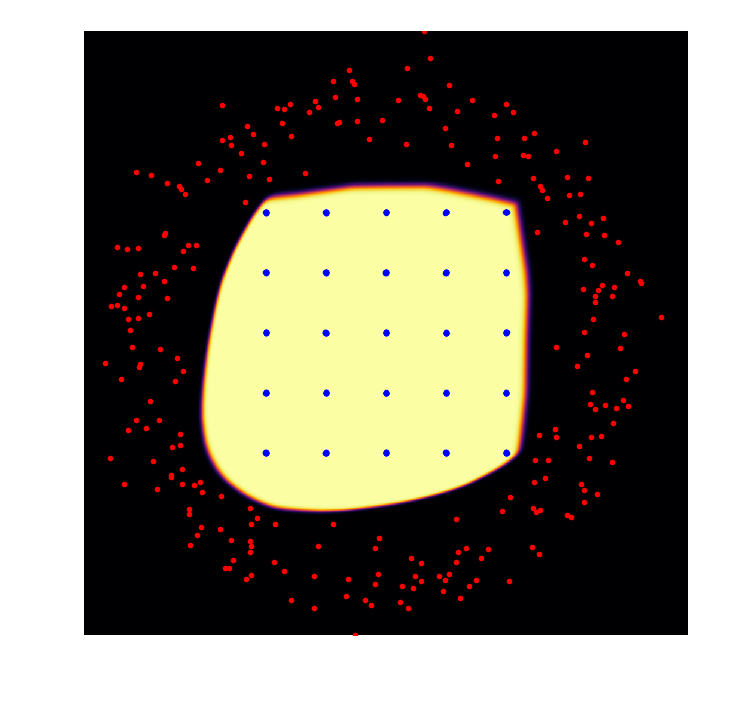

In [6]:
plt.figure(figsize=(4, 4), dpi=200)
ax = plt.subplot(1, 1, 1)
ax.set_axis_off()

for i in range(500):
    sess.run(train_step,feed_dict={detector.x_input: x_train, detector.y_input: y_train})
plot_detector(detector, x_train, y_train, ax, sess)
plt.show()


0.988305 0.0


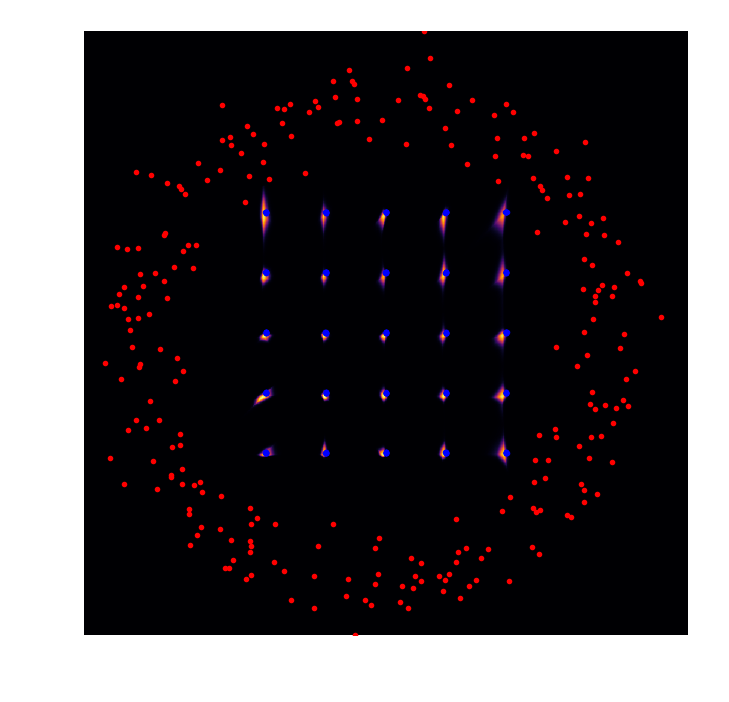

In [7]:
plt.figure(figsize=(4, 4), dpi=200)
ax = plt.subplot(1, 1, 1)
ax.set_axis_off()


# plot_detector(detector, x_train, y_train, ax, class0_marker='o')
for i in range(15000):
            x_train_others_adv = attack.perturb(x_train_others,
                                            None,
                                            sess,
                                            verbose=False)
            x_train_with_adv = np.concatenate(
                [x_train_target, x_train_others_adv])
            y_train_with_adv = np.concatenate([y_train_target, y_train_others])

#             if i % 1000 == 0:
#                 plot_detector(detector,x_train_with_adv, y_train_with_adv, ax, class0_marker='x')
# #                 plt.savefig('painting-twomoods/img{:04d}.png'.format(i + 1), dpi=250)
#                 display.clear_output(wait=True)
#                 display.display(plt.gcf())

            sess.run(train_step,
                     feed_dict={
                         detector.x_input: x_train_with_adv,
                         detector.y_input: y_train_with_adv
                     })
            
#     sess.run(train_step,
#          feed_dict={
#              detector.x_input: x_train,
#              detector.y_input: y_train
#          })
display.clear_output(wait=True)
plot_detector(detector, x_train, y_train, ax, sess)

plt.show()

0.988305 0.0


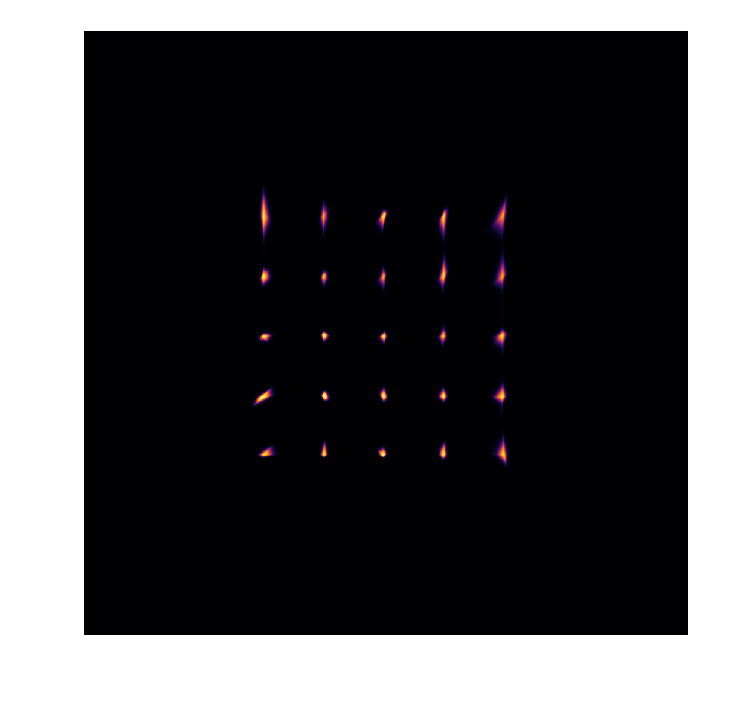

In [8]:
plt.figure(figsize=(4, 4), dpi=200)
ax = plt.subplot(1, 1, 1)
ax.set_axis_off()
plot_detector(detector, x=None, y=None, ax=ax, sess=sess)
plt.show()